# Importing Required Packages

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
import statsmodels.api as sm

from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from sklearn.linear_model import LinearRegression

from sklearn.preprocessing import MinMaxScaler

from scipy.stats import boxcox

import statsmodels.graphics.tsaplots as sgt

import warnings
warnings.filterwarnings("ignore")

# Reading Data

In [2]:
backup_train = pd.read_csv("../Data/train.csv")
backup_test = pd.read_csv("../Data/test.csv")

train_df = backup_train.copy()
test_df = backup_test.copy()

# Features

In [3]:
high_cat = [
    "OverallQual", "ExterQual", "Foundation", "BsmtQual", 
    "KitchenQual", "FireplaceQu", "GarageFinish"
]
high_num = [
    "YearBuilt", "YearRemodAdd", "1stFlrSF", 
    "GrLivArea", "FullBath", "GarageCars"
]

high = high_cat + high_num


medium_cat = ["Neighborhood", "MasVnrType", "HeatingQC", "Fireplaces"]
medium_num = ["MasVnrArea", "GarageYrBlt"]

medium = medium_cat + medium_num


low_cat = [
    "HouseStyle", "Exterior1st", "Exterior2nd", "BsmtExposure", 
    "BsmtFinType1", "GarageType", "OverallCond"
]

low_num = ["LotArea", "BsmtFinSF1", "LotFrontage", "2ndFlrSF"]

low = low_cat + low_num


target = ["SalePrice"]


features = high + medium + low + target

features_df = train_df[features]
features_df["YearBuilt"] = train_df["YrSold"] - train_df["YearBuilt"]
features_df = features_df.rename({"YearBuilt": "YearDiff"}, axis = 1)

features_list = features_df.columns

features_df.head()

,OverallQual,ExterQual,Foundation,BsmtQual,KitchenQual,FireplaceQu,GarageFinish,YearDiff,YearRemodAdd,1stFlrSF,...,Exterior2nd,BsmtExposure,BsmtFinType1,GarageType,OverallCond,LotArea,BsmtFinSF1,LotFrontage,2ndFlrSF,SalePrice
0,7,Gd,PConc,Gd,Gd,NaN,RFn,5,2003,856,...,VinylSd,No,GLQ,Attchd,5,8450,706,65.0,854,208500
1,6,TA,CBlock,Gd,TA,TA,RFn,31,1976,1262,...,MetalSd,Gd,ALQ,Attchd,8,9600,978,80.0,0,181500
2,7,Gd,PConc,Gd,Gd,TA,RFn,7,2002,920,...,VinylSd,Mn,GLQ,Attchd,5,11250,486,68.0,866,223500
3,7,TA,BrkTil,TA,Gd,Gd,Unf,91,1970,961,...,Wd Shng,No,ALQ,Detchd,5,9550,216,60.0,756,140000
4,8,Gd,PConc,Gd,Gd,TA,RFn,8,2000,1145,...,VinylSd,Av,GLQ,Attchd,5,14260,655,84.0,1053,250000


# Null Value Processing

**Null Values**

In [4]:
features_df.isnull().sum()[features_df.isnull().sum() > 0]

BsmtQual         37
FireplaceQu     690
GarageFinish     81
MasVnrType        8
MasVnrArea        8
GarageYrBlt      81
BsmtExposure     38
BsmtFinType1     37
GarageType       81
LotFrontage     259
dtype: int64

**Null %age**

In [5]:
(features_df.isnull().sum()[features_df.isnull().sum() > 0] / train_df.shape[0]) * 100

BsmtQual         2.534247
FireplaceQu     47.260274
GarageFinish     5.547945
MasVnrType       0.547945
MasVnrArea       0.547945
GarageYrBlt      5.547945
BsmtExposure     2.602740
BsmtFinType1     2.534247
GarageType       5.547945
LotFrontage     17.739726
dtype: float64

## BsmtQual

**Replace Null values with some identifier that indicates the absence of basement: "NA"**

In [6]:
features_df["BsmtQual"] = features_df["BsmtQual"].fillna("NA")

## FireplaceQu

**Replace Null values with some identifier that indicates the absence of fireplace: "NA"**

In [7]:
features_df["FireplaceQu"] = features_df["FireplaceQu"].fillna("NA")

## GarageFinish

**Replace Null values with some identifier that indicates the absence of garage: "NA"**

In [8]:
features_df["GarageFinish"] = features_df["GarageFinish"].fillna("NA")

## MasVnrType

**Replace Null values with some identifier that indicates the absence of MasVnr: "NA"**

In [9]:
features_df["MasVnrType"] = features_df["MasVnrType"].fillna("NA")

## MasVnrArea

**SalePrice Description when the MasVnrArea is Null**

count         8.000000
mean     236484.250000
std       93964.474968
min      182000.000000
25%      196150.000000
50%      203287.000000
75%      221625.000000
max      465000.000000
Name: SalePrice, dtype: float64


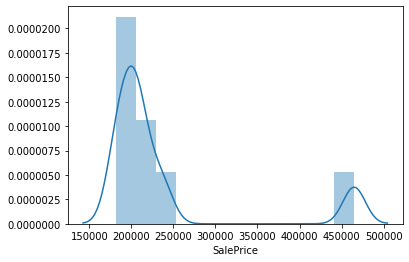

In [10]:
print(features_df[features_df["MasVnrArea"].isnull()]["SalePrice"].describe())

sns.distplot(features_df[features_df["MasVnrArea"].isnull()]["SalePrice"])
plt.show()

**What does the MasVnrArea look like near the SalePrice shown in the above distribution**

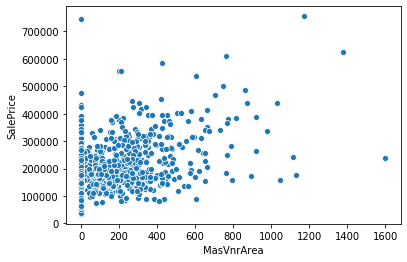

In [11]:
sns.scatterplot(x = "MasVnrArea", y = "SalePrice", data = features_df)
plt.show()

**Since the number of nulls are very limited, we can simply fill them with 0's**

In [12]:
features_df["MasVnrArea"] = features_df["MasVnrArea"].fillna(0)

## GarageYrBlt

**Replace Null values with some identifier that indicates the absence of garage: "NA"**

In [13]:
features_df["GarageYrBlt"] = features_df["GarageYrBlt"].fillna("NA")

**Since this is numeric feature, this technique may cause problems in modeling**

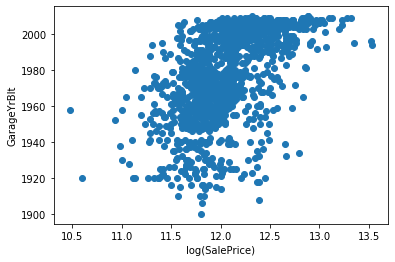

In [14]:
df = features_df[features_df["GarageYrBlt"] != "NA"][["GarageYrBlt", "SalePrice"]]

plt.scatter(np.log(df["SalePrice"]), df["GarageYrBlt"])

plt.xlabel("log(SalePrice)")
plt.ylabel("GarageYrBlt")

plt.show()

Coefficient: [0.00015196]	 Intercept: 1950.3214823815215


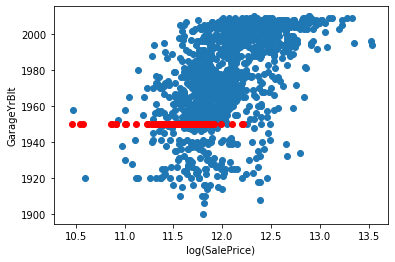

,OverallQual,ExterQual,Foundation,BsmtQual,KitchenQual,FireplaceQu,GarageFinish,YearDiff,YearRemodAdd,1stFlrSF,...,Exterior2nd,BsmtExposure,BsmtFinType1,GarageType,OverallCond,LotArea,BsmtFinSF1,LotFrontage,2ndFlrSF,SalePrice
0,7,Gd,PConc,Gd,Gd,NA,RFn,5,2003,856,...,VinylSd,No,GLQ,Attchd,5,8450,706,65.0,854,208500
1,6,TA,CBlock,Gd,TA,TA,RFn,31,1976,1262,...,MetalSd,Gd,ALQ,Attchd,8,9600,978,80.0,0,181500
2,7,Gd,PConc,Gd,Gd,TA,RFn,7,2002,920,...,VinylSd,Mn,GLQ,Attchd,5,11250,486,68.0,866,223500
3,7,TA,BrkTil,TA,Gd,Gd,Unf,91,1970,961,...,Wd Shng,No,ALQ,Detchd,5,9550,216,60.0,756,140000
4,8,Gd,PConc,Gd,Gd,TA,RFn,8,2000,1145,...,VinylSd,Av,GLQ,Attchd,5,14260,655,84.0,1053,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,6,TA,PConc,Gd,TA,TA,RFn,8,2000,953,...,VinylSd,No,Unf,Attchd,5,7917,0,62.0,694,175000
1456,6,TA,CBlock,Gd,TA,TA,Unf,32,1988,2073,...,Plywood,No,ALQ,Attchd,6,13175,790,85.0,0,210000
1457,7,Ex,Stone,TA,Gd,Gd,RFn,69,2006,1188,...,CmentBd,No,GLQ,Attchd,9,9042,275,66.0,1152,266500
1458,5,TA,CBlock,TA,Gd,NA,Unf,60,1996,1078,...,MetalSd,Mn,GLQ,Attchd,6,9717,49,68.0,0,142125


In [15]:
X, y = df["SalePrice"].values, df["GarageYrBlt"].values

lr = LinearRegression().fit(X.reshape((-1, 1)), y)
print(f"Coefficient: {lr.coef_}\t Intercept: {lr.intercept_}")

X_test = np.log(features_df[features_df["GarageYrBlt"] == "NA"]["SalePrice"].values.reshape((-1, 1)))
null_vals = lr.predict(X_test)
y_preds = null_vals.astype("int")

plt.scatter(np.log(df["SalePrice"]), df["GarageYrBlt"])
plt.scatter(X_test, y_preds, color = "red")

plt.xlabel("log(SalePrice)")
plt.ylabel("GarageYrBlt")

plt.show()

features_df

In [16]:
null_indices = features_df[features_df["GarageYrBlt"] == "NA"].index
features_df.loc[null_indices, "GarageYrBlt"] = y_preds

## BsmtExposure

**There are 37 houses with no basement. This feature has one missing basement.**

In [17]:
set(features_df[features_df["BsmtExposure"].isnull()]["BsmtExposure"].index).difference(train_df[train_df["BsmtQual"].isnull()]["BsmtQual"].index)

{948}

**Anaysing the sole null value**

In [18]:
features_df.loc[948, ["BsmtQual", "BsmtExposure", "BsmtFinType1", "SalePrice"]]

BsmtQual            Gd
BsmtExposure       NaN
BsmtFinType1       Unf
SalePrice       192500
Name: 948, dtype: object

**Analysing other basement features with SalePrice**

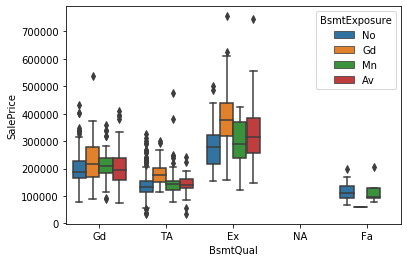

In [19]:
sns.boxplot(x = "BsmtQual", y = "SalePrice", hue = "BsmtExposure", data = features_df)
plt.show()

**Basement Exposure with SalePrice**

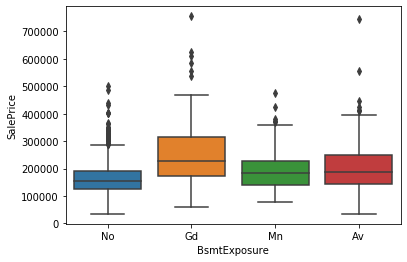

In [20]:
sns.boxplot(x = "BsmtExposure", y = "SalePrice", data = features_df)
plt.show()

**Based on the SalePrice, 'Mn' seems like a good candidate for the missing value.**

In [21]:
features_df.at[948, "BsmtExposure"] = "Mn"

**Filling the rest of the nulls with "NA"**

In [22]:
features_df["BsmtExposure"].isnull().sum()

37

In [23]:
features_df["BsmtExposure"] = features_df["BsmtExposure"].fillna("NA")

## BsmtFinType1

**Filling Null values (No Basement) with "NA"**

In [24]:
features_df["BsmtFinType1"] = features_df["BsmtFinType1"].fillna("NA")

## GarageType

**Filling null values with "NA", repersenting no garage.**

In [25]:
features_df["GarageType"] = features_df["GarageType"].fillna("NA")

## LotFrontage

In [26]:
df = features_df[["LotFrontage", "SalePrice"]]

**Distribution of SalePrice when LotFrontage is Null**

In [27]:
df[df["LotFrontage"].isnull()]["SalePrice"].describe()

count       259.000000
mean     181620.073359
std       57841.775706
min       61000.000000
25%      143375.000000
50%      172400.000000
75%      215000.000000
max      466500.000000
Name: SalePrice, dtype: float64

**Using Linear Regression to fill null values**

Coefficient: [0.00010132]	 Intercept: 51.332091561218505


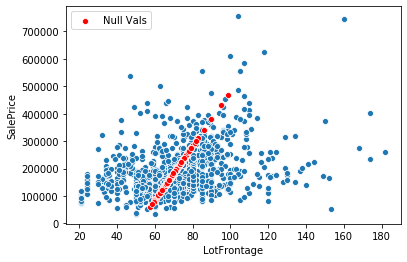

In [28]:
# Predicting Null Values
X, y = df[df["LotFrontage"]<300]["SalePrice"].values, df[df["LotFrontage"]<300]["LotFrontage"].values

lr = LinearRegression().fit(X.reshape((-1, 1)), y)
print(f"Coefficient: {lr.coef_}\t Intercept: {lr.intercept_}")

null_vals = lr.predict(df[df["LotFrontage"].isnull()]["SalePrice"].values.reshape(-1, 1))

# Storing Null Values
df_null = df[df["LotFrontage"].isnull()]
df_null["Null_vals"] = null_vals

# Plotting Null Values
fig, ax = plt.subplots()

sns.scatterplot(x = "LotFrontage", y = "SalePrice", data = df[df["LotFrontage"]<300], ax = ax)
sns.scatterplot(x = "Null_vals", y = "SalePrice", data = df_null, color = "red", ax = ax, label = "Null Vals")

ax.set_xlabel("LotFrontage")

plt.legend()
plt.show()

**Adding these null values to the features_df**

In [29]:
null_indices = features_df[features_df["LotFrontage"].isnull()].index

null_preds = lr.predict(df[df["LotFrontage"].isnull()]["SalePrice"].values.reshape(-1, 1))
# null_preds
features_df.loc[null_indices, "LotFrontage"] = null_preds

## Filled Null Values

In [30]:
features_df.isnull().sum()

OverallQual     0
ExterQual       0
Foundation      0
BsmtQual        0
KitchenQual     0
FireplaceQu     0
GarageFinish    0
YearDiff        0
YearRemodAdd    0
1stFlrSF        0
GrLivArea       0
FullBath        0
GarageCars      0
Neighborhood    0
MasVnrType      0
HeatingQC       0
Fireplaces      0
MasVnrArea      0
GarageYrBlt     0
HouseStyle      0
Exterior1st     0
Exterior2nd     0
BsmtExposure    0
BsmtFinType1    0
GarageType      0
OverallCond     0
LotArea         0
BsmtFinSF1      0
LotFrontage     0
2ndFlrSF        0
SalePrice       0
dtype: int64

# Encoding Categorical Features

In [31]:
def get_map(feature, target, df):
    keys = df.groupby(by = feature)[target].median().sort_values().index
    vals = [i for i in range(keys.shape[0])]

    map_dict = {}
    for key, val in zip(keys, vals):
        map_dict[key] = val
    return map_dict

In [32]:
def plot_dist(feature, df, L):
    e = pow(10, -20)
    
    fig, ax = plt.subplots(2, 2, figsize = (10, 6))

    sns.distplot(df[feature], ax = ax[0, 0])
    sm.qqplot(df[feature], line = "q", ax = ax[0, 1])

    sns.distplot(boxcox(df[feature]+e, L), ax = ax[1, 0])
    sm.qqplot(boxcox(df[feature]+e, L), line = "q", ax = ax[1, 1])
    
    ax[1, 0].set_xlabel(f"Transformed {feature}")

    plt.show()

In [33]:
def plot_heat(feature, target, df, L):
    e = pow(10, -20)
    
    data = df[[feature, target]]
    data["Trans_Feature"] = boxcox(data[feature]+e, L)
    data["Trans_Target"] = np.log(data[target])

    fig, ax = plt.subplots(2, 2, figsize = (10, 6))

    sns.heatmap(data[[feature, target]].corr(), annot = True, ax = ax[0, 0])
    sns.heatmap(data[[feature, "Trans_Target"]].corr(), annot = True, ax = ax[0, 1])
    sns.heatmap(data[["Trans_Feature", target]].corr(), annot = True, ax = ax[1, 0])
    sns.heatmap(data[["Trans_Feature", "Trans_Target"]].corr(), annot = True, ax = ax[1, 1])
    
    plt.show()

## High

### OverallQual

**Already Encoded.**

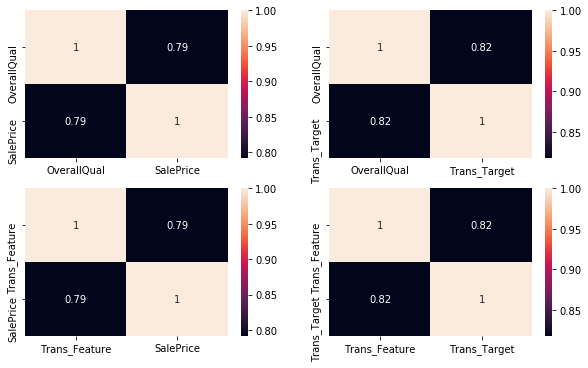

In [34]:
plot_heat("OverallQual", "SalePrice", features_df, 1)

### ExterQual

In [35]:
map_dict = get_map("ExterQual", "SalePrice", features_df)
print(map_dict)

features_df["ExterQual"] = features_df["ExterQual"].map(map_dict)

{'Fa': 0, 'TA': 1, 'Gd': 2, 'Ex': 3}


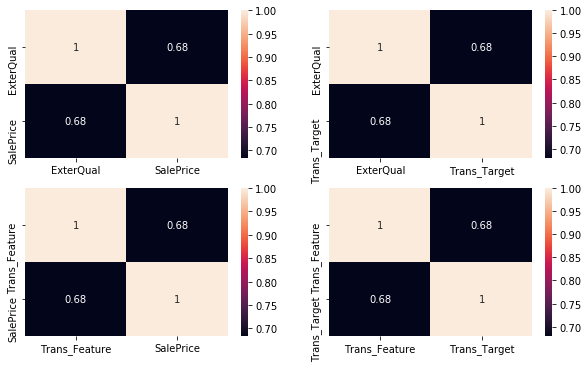

In [36]:
plot_heat("ExterQual", "SalePrice", features_df, 1)

### Foundation

**Using mapping from the function above**

In [37]:
map_dict = get_map("Foundation", "SalePrice", features_df)
print(map_dict)

features_df["Foundation"] = features_df["Foundation"].map(map_dict)

{'Slab': 0, 'BrkTil': 1, 'Stone': 2, 'CBlock': 3, 'Wood': 4, 'PConc': 5}


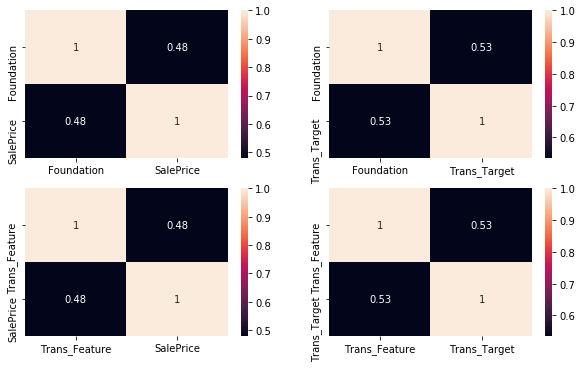

In [38]:
plot_heat("Foundation", "SalePrice", features_df, 1)

**Using mapping discovered in exploration**

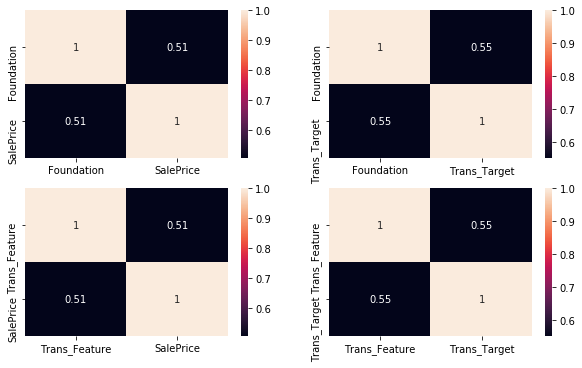

In [39]:
df = train_df[["Foundation", "SalePrice"]]
df["Foundation"] = df["Foundation"].map({
                                            "Slab": 1, "BrkTil": 2, "CBlock": 3,
                                            "Stone": 4, "Wood": 5, "PConc": 6
                                        })
plot_heat("Foundation", "SalePrice", df, 1)

In [40]:
features_df["Foundation"] = df["Foundation"]

### BsmtQual

In [41]:
map_dict = get_map("BsmtQual", "SalePrice", features_df)
print(map_dict)

features_df["BsmtQual"] = features_df["BsmtQual"].map(map_dict)

{'NA': 0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex': 4}


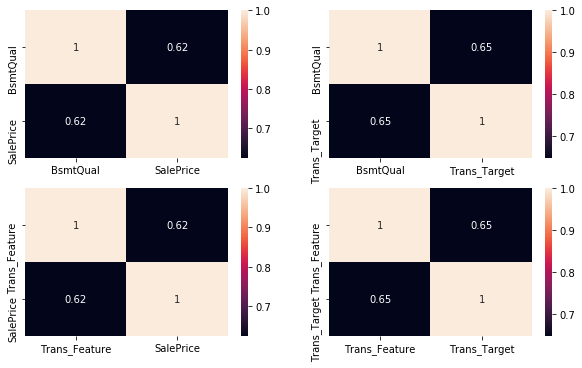

In [42]:
plot_heat("BsmtQual", "SalePrice", features_df, 1)

### KitchenQual

In [43]:
map_dict = get_map("KitchenQual", "SalePrice", features_df)
print(map_dict)

features_df["KitchenQual"] = features_df["KitchenQual"].map(map_dict)

{'Fa': 0, 'TA': 1, 'Gd': 2, 'Ex': 3}


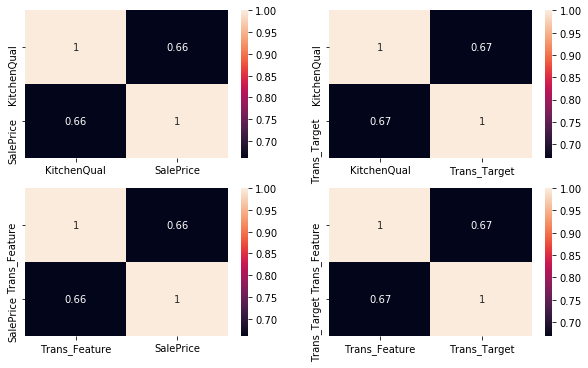

In [44]:
plot_heat("KitchenQual", "SalePrice", features_df, 1)

### FireplaceQu

In [45]:
map_dict = get_map("FireplaceQu", "SalePrice", features_df)
print(map_dict)

features_df["FireplaceQu"] = features_df["FireplaceQu"].map(map_dict)

{'Po': 0, 'NA': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}


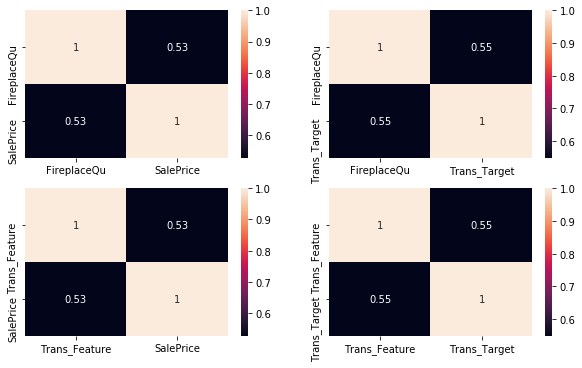

In [46]:
plot_heat("FireplaceQu", "SalePrice", features_df, 1)

### GarageFinish

In [47]:
map_dict = get_map("GarageFinish", "SalePrice", features_df)
print(map_dict)

features_df["GarageFinish"] = features_df["GarageFinish"].map(map_dict)

{'NA': 0, 'Unf': 1, 'RFn': 2, 'Fin': 3}


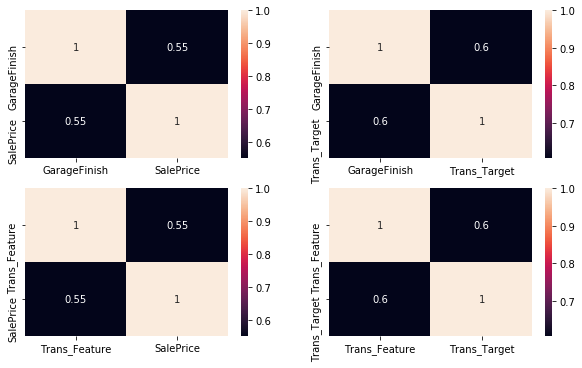

In [48]:
plot_heat("GarageFinish", "SalePrice", features_df, 1)

## Medium

### Neighborhood

In [49]:
map_dict = get_map("Neighborhood", "SalePrice", features_df)
print(map_dict)

features_df["Neighborhood"] = features_df["Neighborhood"].map(map_dict)

{'MeadowV': 0, 'IDOTRR': 1, 'BrDale': 2, 'OldTown': 3, 'Edwards': 4, 'BrkSide': 5, 'Sawyer': 6, 'Blueste': 7, 'SWISU': 8, 'NAmes': 9, 'NPkVill': 10, 'Mitchel': 11, 'SawyerW': 12, 'Gilbert': 13, 'NWAmes': 14, 'Blmngtn': 15, 'CollgCr': 16, 'ClearCr': 17, 'Crawfor': 18, 'Veenker': 19, 'Somerst': 20, 'Timber': 21, 'StoneBr': 22, 'NoRidge': 23, 'NridgHt': 24}


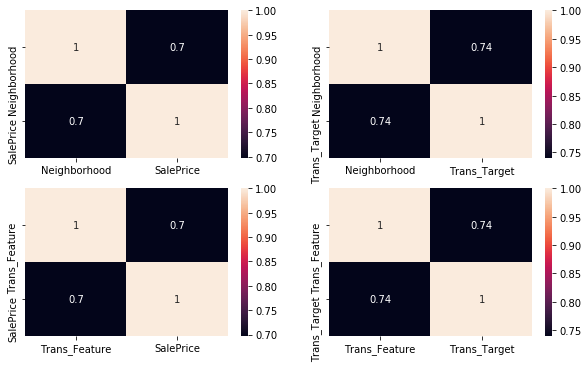

In [50]:
plot_heat("Neighborhood", "SalePrice", features_df, 1)

### MasVnrType

In [51]:
map_dict = get_map("MasVnrType", "SalePrice", features_df)
print(map_dict)

features_df["MasVnrType"] = features_df["MasVnrType"].map(map_dict)

{'BrkCmn': 0, 'None': 1, 'BrkFace': 2, 'NA': 3, 'Stone': 4}


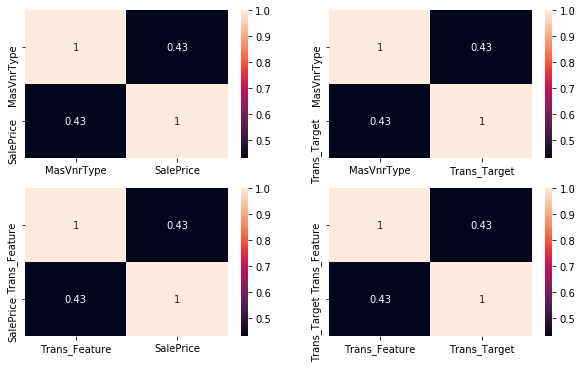

In [52]:
plot_heat("MasVnrType", "SalePrice", features_df, 1)

### HeatingQC

In [53]:
map_dict = get_map("HeatingQC", "SalePrice", features_df)
print(map_dict)

features_df["HeatingQC"] = features_df["HeatingQC"].map(map_dict)

{'Po': 0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex': 4}


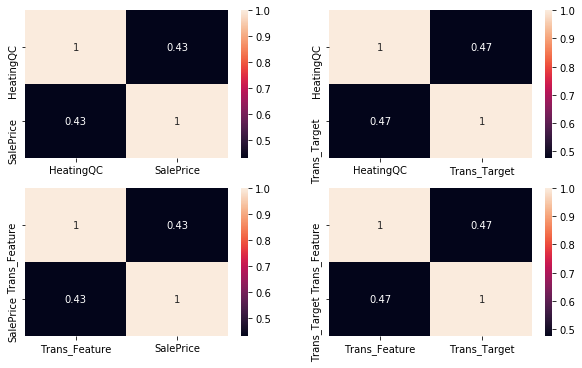

In [54]:
plot_heat("HeatingQC", "SalePrice", features_df, 1)

### Fireplaces

**Already Encoded.**

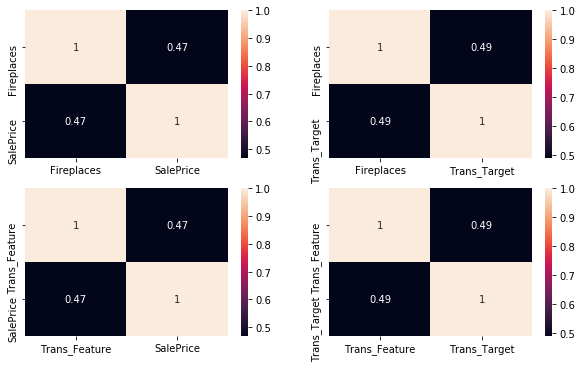

In [55]:
plot_heat("Fireplaces", "SalePrice", features_df, 1)

## Low

### HouseStyle

In [56]:
map_dict = get_map("HouseStyle", "SalePrice", features_df)
print(map_dict)

features_df["HouseStyle"] = features_df["HouseStyle"].map(map_dict)

{'1.5Unf': 0, '1.5Fin': 1, '2.5Unf': 2, 'SFoyer': 3, '1Story': 4, 'SLvl': 5, '2Story': 6, '2.5Fin': 7}


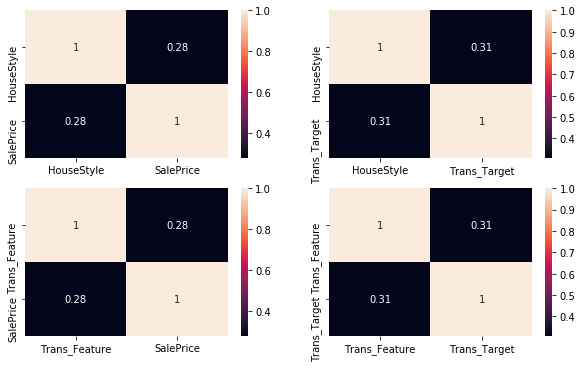

In [57]:
plot_heat("HouseStyle", "SalePrice", features_df, 1)

### Exterior1st

In [58]:
map_dict = get_map("Exterior1st", "SalePrice", features_df)
print(map_dict)

features_df["Exterior1st"] = features_df["Exterior1st"].map(map_dict)

{'BrkComm': 0, 'AsphShn': 1, 'CBlock': 2, 'AsbShng': 3, 'WdShing': 4, 'Wd Sdng': 5, 'MetalSd': 6, 'Stucco': 7, 'HdBoard': 8, 'BrkFace': 9, 'Plywood': 10, 'VinylSd': 11, 'CemntBd': 12, 'Stone': 13, 'ImStucc': 14}


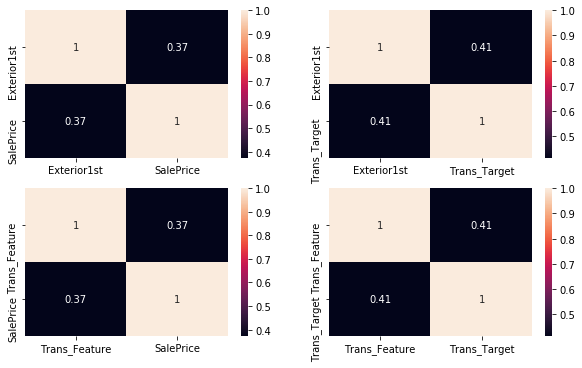

In [59]:
plot_heat("Exterior1st", "SalePrice", features_df, 1)

### Exterior2nd

In [60]:
map_dict = get_map("Exterior2nd", "SalePrice", features_df)
print(map_dict)

features_df["Exterior2nd"] = features_df["Exterior2nd"].map(map_dict)

{'CBlock': 0, 'AsbShng': 1, 'Wd Sdng': 2, 'Wd Shng': 3, 'MetalSd': 4, 'AsphShn': 5, 'Stucco': 6, 'Brk Cmn': 7, 'HdBoard': 8, 'BrkFace': 9, 'Plywood': 10, 'Stone': 11, 'ImStucc': 12, 'VinylSd': 13, 'CmentBd': 14, 'Other': 15}


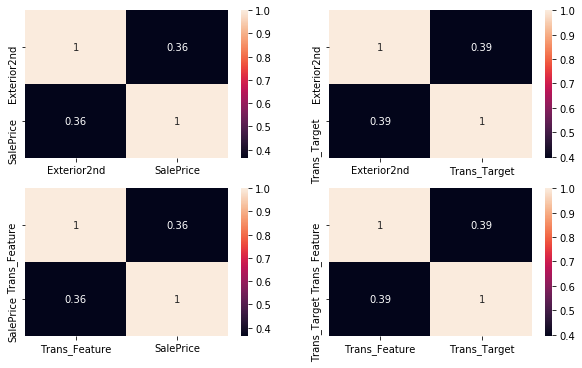

In [61]:
plot_heat("Exterior2nd", "SalePrice", features_df, 1)

### BsmtExposure

In [62]:
map_dict = get_map("BsmtExposure", "SalePrice", features_df)
print(map_dict)

features_df["BsmtExposure"] = features_df["BsmtExposure"].map(map_dict)

{'NA': 0, 'No': 1, 'Mn': 2, 'Av': 3, 'Gd': 4}


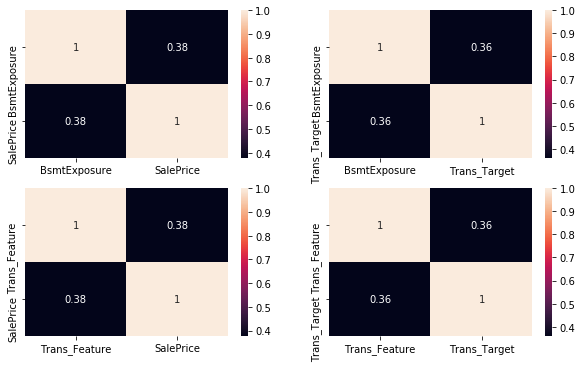

In [63]:
plot_heat("BsmtExposure", "SalePrice", features_df, 1)

### BsmtFinType1

In [64]:
map_dict = get_map("BsmtFinType1", "SalePrice", features_df)
print(map_dict)

features_df["BsmtFinType1"] = features_df["BsmtFinType1"].map(map_dict)

{'NA': 0, 'LwQ': 1, 'BLQ': 2, 'Rec': 3, 'ALQ': 4, 'Unf': 5, 'GLQ': 6}


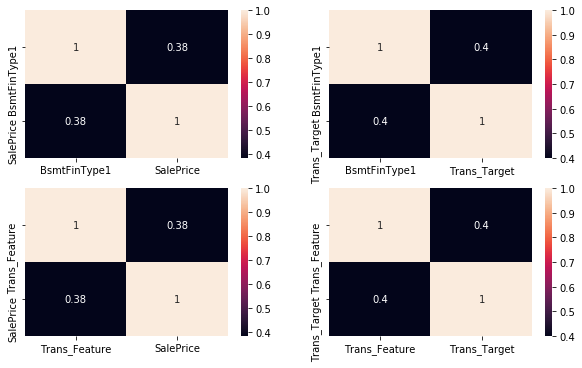

In [65]:
plot_heat("BsmtFinType1", "SalePrice", features_df, 1)

### GarageType

In [66]:
map_dict = get_map("GarageType", "SalePrice", features_df)
print(map_dict)

features_df["GarageType"] = features_df["GarageType"].map(map_dict)

{'NA': 0, 'CarPort': 1, 'Detchd': 2, 'Basment': 3, '2Types': 4, 'Attchd': 5, 'BuiltIn': 6}


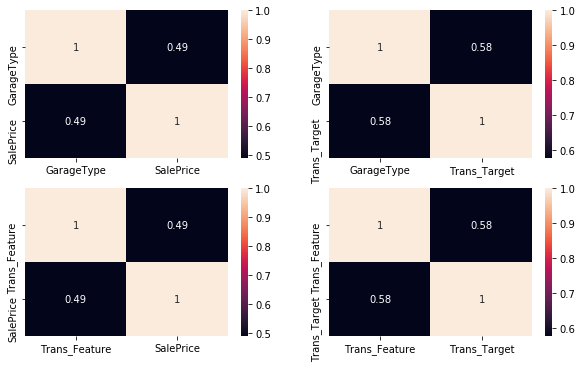

In [67]:
plot_heat("GarageType", "SalePrice", features_df, 1)

### OverallCond

**Already Encoded**

In [68]:
map_dict = get_map("OverallCond", "SalePrice", features_df)
print(map_dict)

features_df["OverallCond"] = features_df["OverallCond"].map(map_dict)

{1: 0, 2: 1, 3: 2, 4: 3, 8: 4, 6: 5, 7: 6, 9: 7, 5: 8}


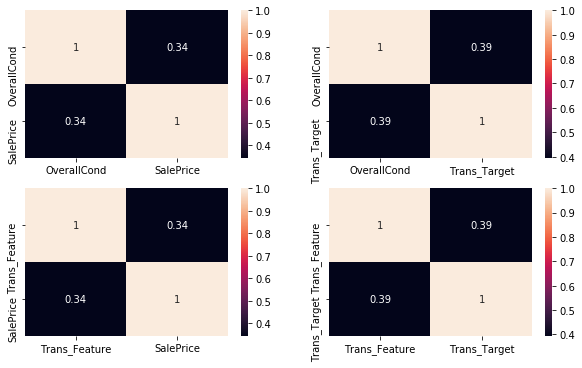

In [69]:
plot_heat("OverallCond", "SalePrice", features_df, 1)

# Numeric Features Processing

## High

### YearDiff

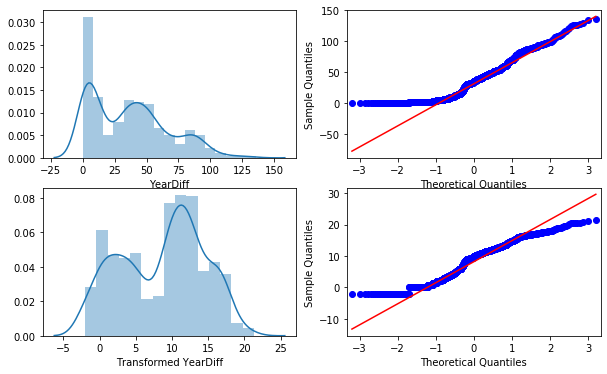

In [70]:
plot_dist("YearDiff", features_df, 0.5)

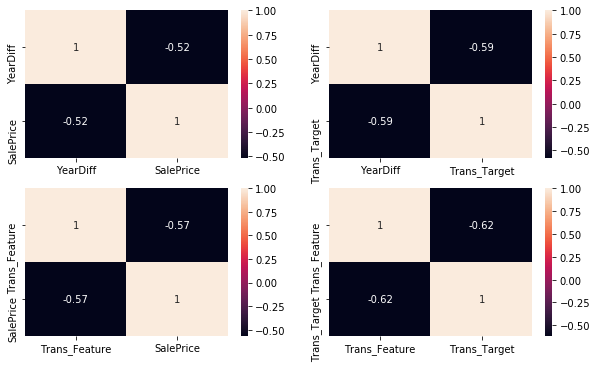

In [71]:
plot_heat("YearDiff", "SalePrice", features_df, 0.5)

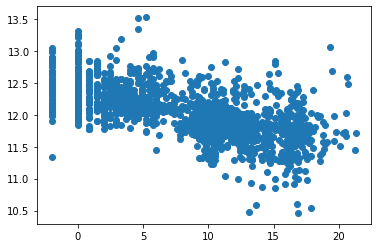

In [72]:
e = pow(10, -20)
plt.scatter(boxcox(features_df["YearDiff"] + e, 0.5), np.log(features_df["SalePrice"]))
plt.show()

features_df["YearDiff"] = boxcox(features_df["YearDiff"] + e, 0.5)

### YearRemodAdd

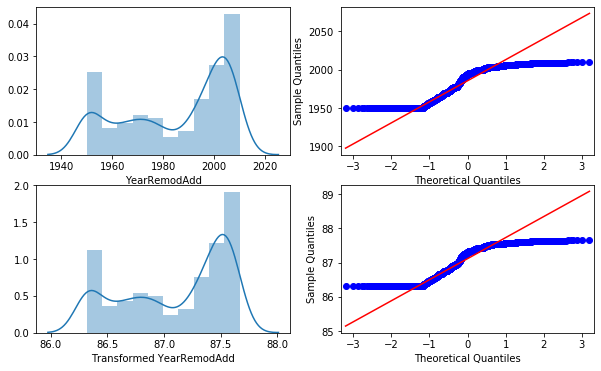

In [73]:
plot_dist("YearRemodAdd", features_df, 0.5)

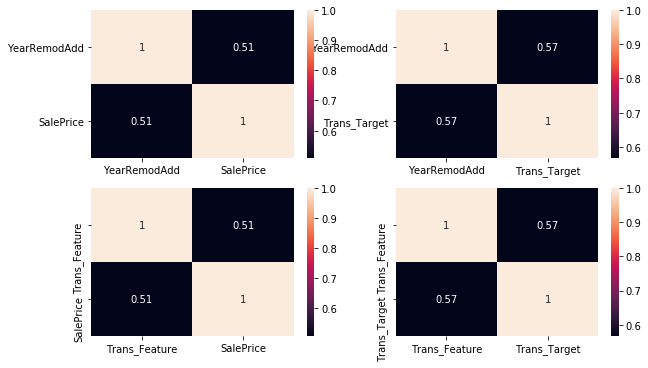

In [74]:
plot_heat("YearRemodAdd", "SalePrice", features_df, 0.5)

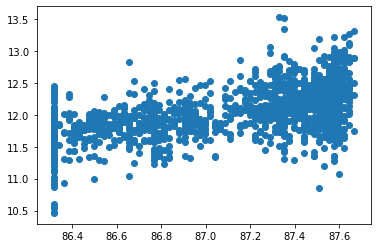

In [75]:
e = pow(10, -20)
plt.scatter(boxcox(features_df["YearRemodAdd"] + e, 0.5), np.log(features_df["SalePrice"]))
plt.show()

features_df["YearRemodAdd"] = boxcox(features_df["YearRemodAdd"] + e, 0.5)

### 1stFlrSF

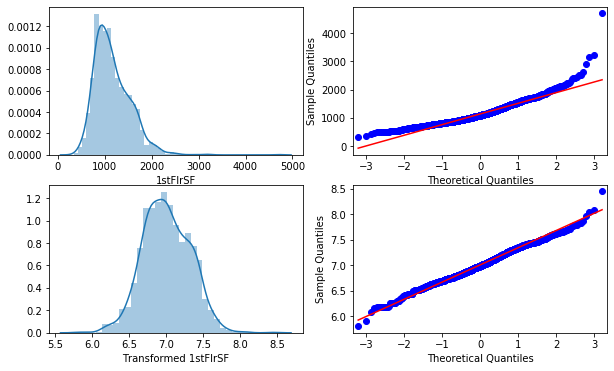

In [76]:
plot_dist("1stFlrSF", features_df, 0)

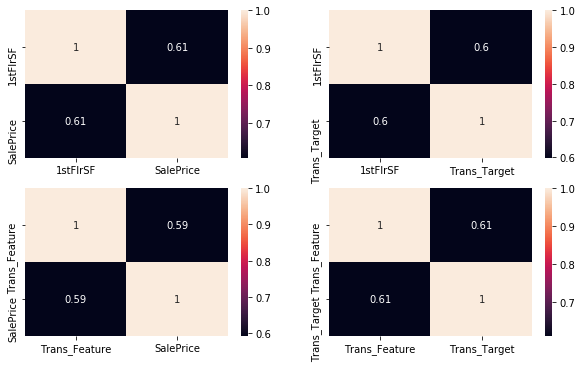

In [77]:
plot_heat("1stFlrSF", "SalePrice", features_df, 0)

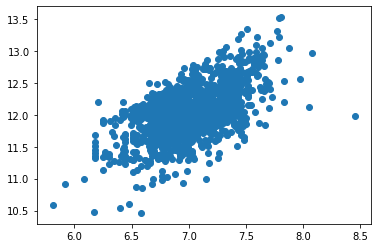

In [78]:
e = pow(10, -20)
plt.scatter(boxcox(features_df["1stFlrSF"] + e, 0), np.log(features_df["SalePrice"]))
plt.show()

features_df["1stFlrSF"] = boxcox(features_df["1stFlrSF"] + e, 0)

### GrLivArea

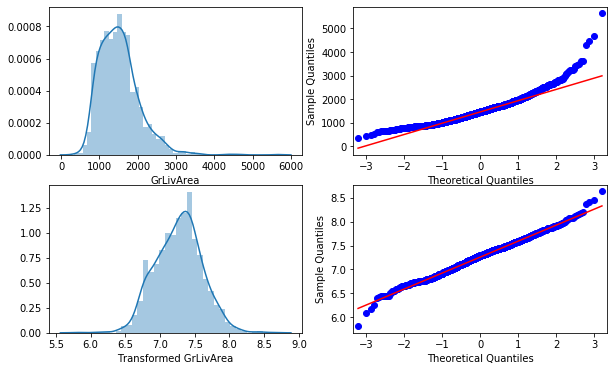

In [79]:
plot_dist("GrLivArea", features_df, 0)

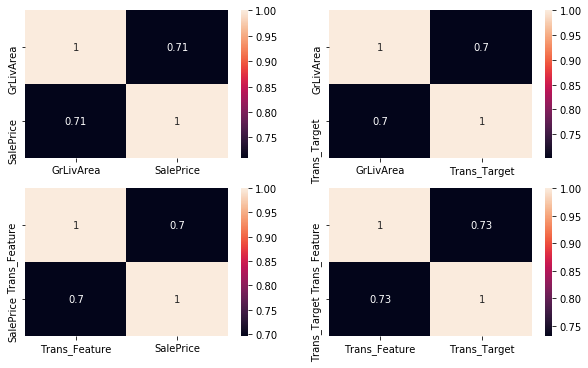

In [80]:
plot_heat("GrLivArea", "SalePrice", features_df, 0)

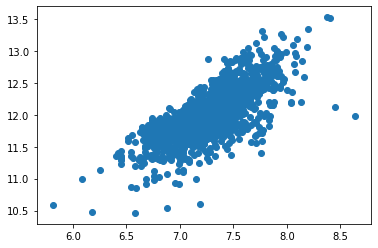

In [81]:
e = pow(10, -20)
plt.scatter(boxcox(features_df["GrLivArea"] + e, 0), np.log(features_df["SalePrice"]))
plt.show()

features_df["GrLivArea"] = boxcox(features_df["GrLivArea"] + e, 0)

### FullBath

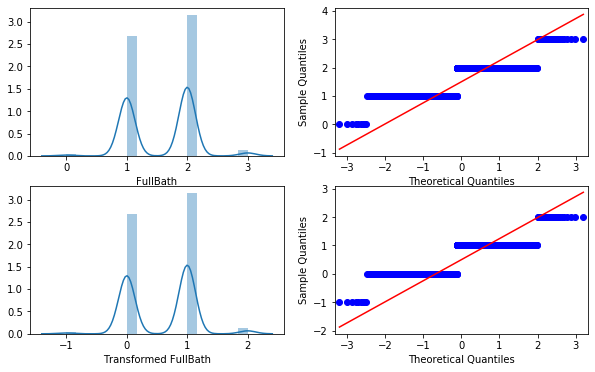

In [82]:
plot_dist("FullBath", features_df, 1)

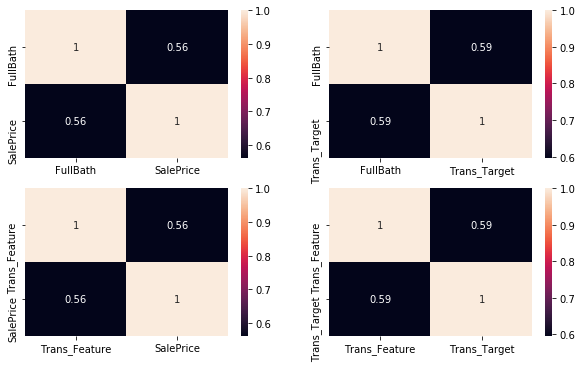

In [83]:
plot_heat("FullBath", "SalePrice", features_df, 1)

### GarageCars

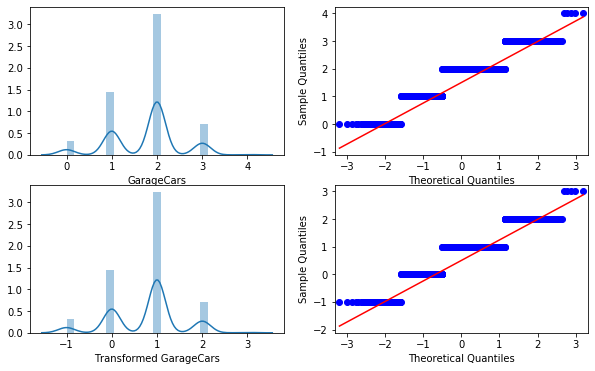

In [84]:
plot_dist("GarageCars", features_df, 1)

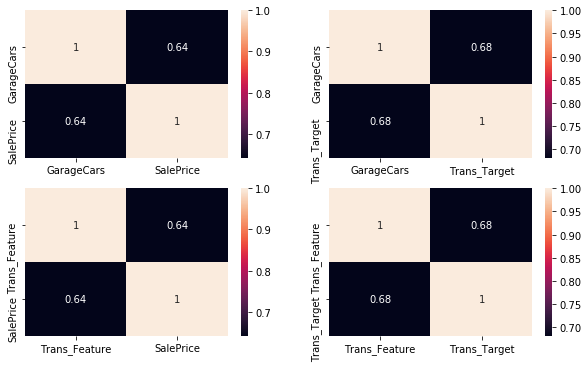

In [85]:
plot_heat("GarageCars", "SalePrice", features_df, 1)

## Medium

### MasVnrArea

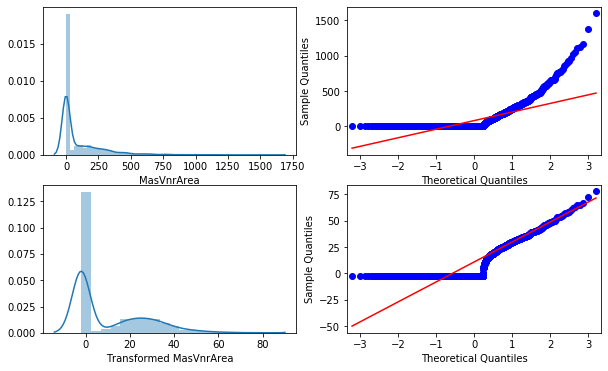

In [86]:
plot_dist("MasVnrArea", features_df, 0.5)

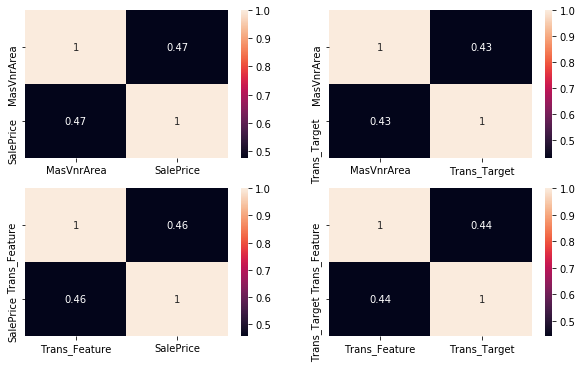

In [87]:
plot_heat("MasVnrArea", "SalePrice", features_df, 0.5)

**Without 0's**

In [88]:
df = features_df[features_df["MasVnrArea"] > 0][["MasVnrArea", "SalePrice"]]
df.shape

(591, 2)

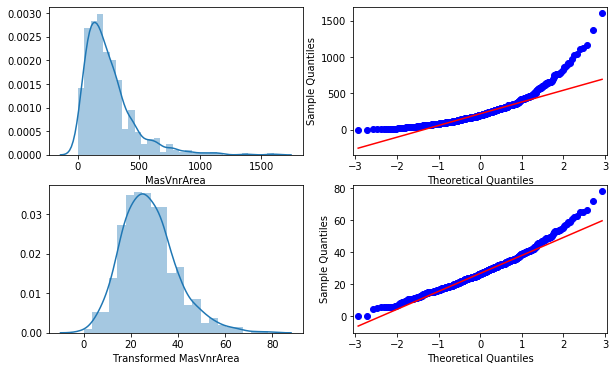

In [89]:
plot_dist("MasVnrArea", df, 0.5)

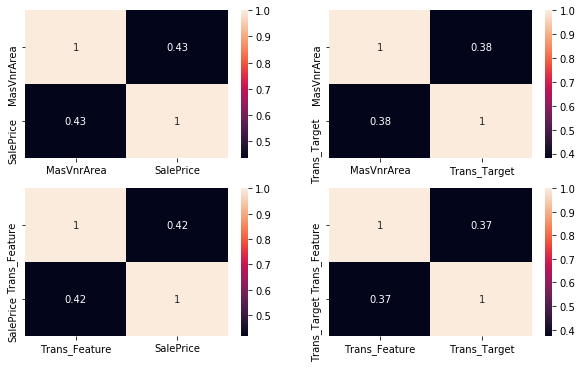

In [90]:
plot_heat("MasVnrArea", "SalePrice", df, 0.5)

### GarageYrBlt

In [91]:
df = features_df[["GarageYrBlt", "SalePrice"]]
df["GarageYrBlt"] = df["GarageYrBlt"].astype("int")
df.shape

(1460, 2)

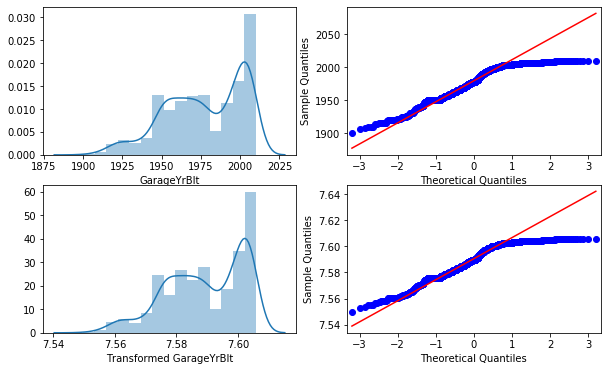

In [92]:
plot_dist("GarageYrBlt", df, 0)

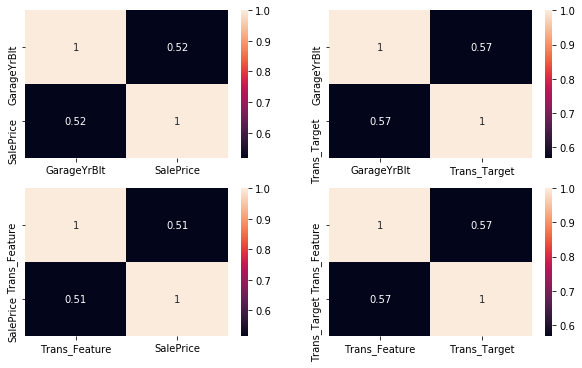

In [93]:
plot_heat("GarageYrBlt", "SalePrice", df, 0)

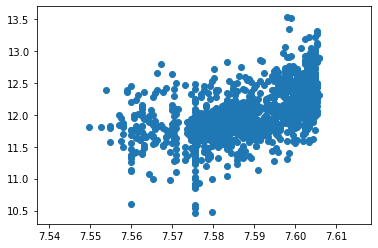

In [94]:
e = pow(10, -20)

series = features_df["GarageYrBlt"].astype(int)
target = features_df["SalePrice"]

plt.scatter(boxcox(series + e, 0), np.log(target))
plt.show()

features_df["GarageYrBlt"] = series

In [95]:
features_df["no_garage"] = np.where(train_df["GarageYrBlt"].isnull(), 1, 0)

## Low

### LotArea

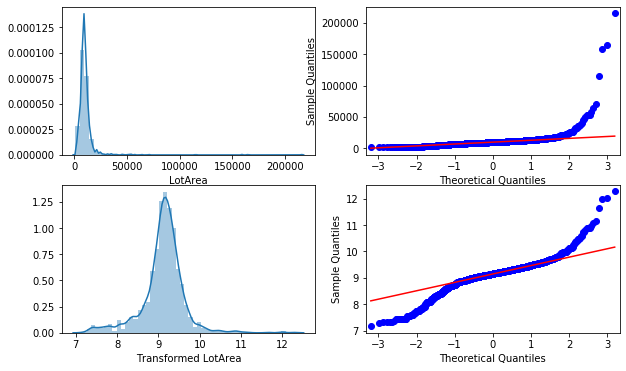

In [96]:
plot_dist("LotArea", features_df, 0)

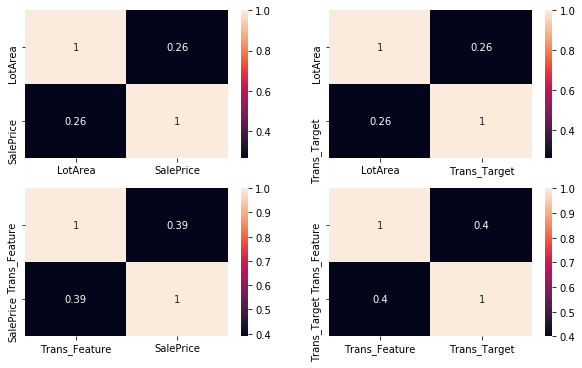

In [97]:
plot_heat("LotArea", "SalePrice", features_df, 0)

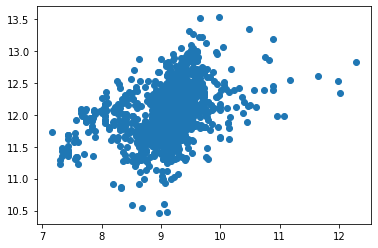

In [98]:
e = pow(10, -20)
plt.scatter(boxcox(features_df["LotArea"] + e, 0), np.log(features_df["SalePrice"]))
plt.show()

features_df["LotArea"] = boxcox(features_df["LotArea"] + e, 0)

### BsmtFinSF1

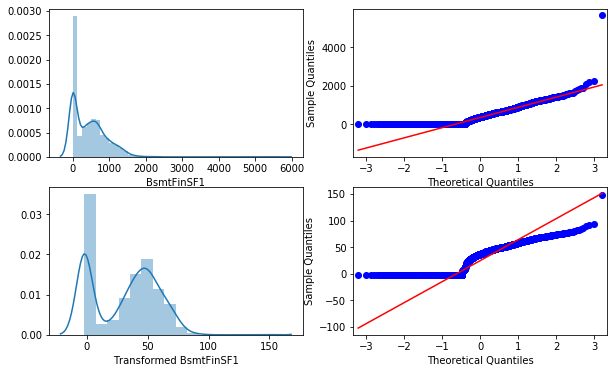

In [99]:
plot_dist("BsmtFinSF1", features_df, 0.5)

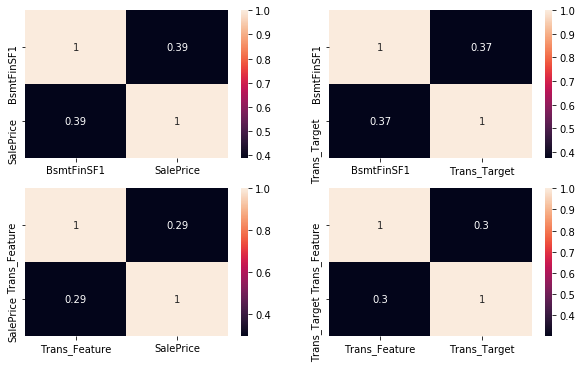

In [100]:
plot_heat("BsmtFinSF1", "SalePrice", features_df, 0.5)

**Without 0's**

In [101]:
df = features_df[features_df["BsmtFinSF1"] > 0][["BsmtFinSF1", "SalePrice"]]
df.shape

(993, 2)

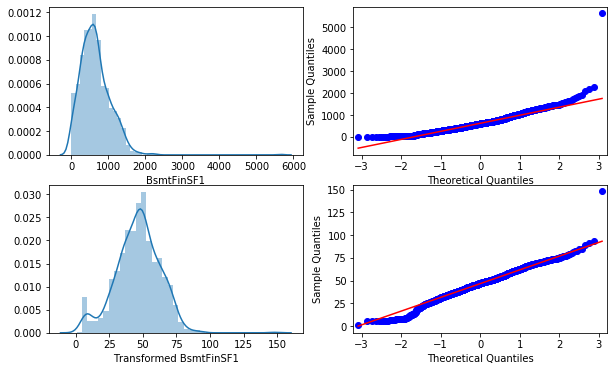

In [102]:
plot_dist("BsmtFinSF1", df, 0.5)

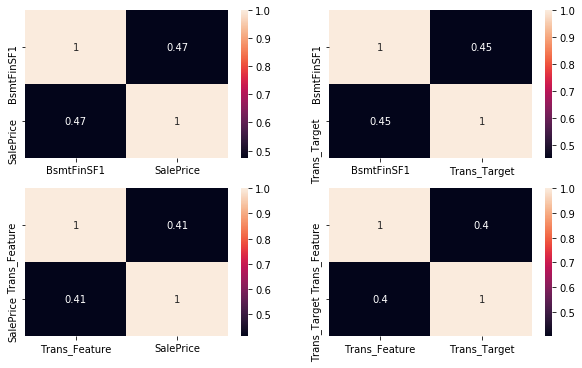

In [103]:
plot_heat("BsmtFinSF1", "SalePrice", df, 0.5)

In [104]:
features_df["is_BsmtFinSF1_0"] = np.where(features_df["BsmtFinSF1"] == 0, 1, 0)

### LotFrontage

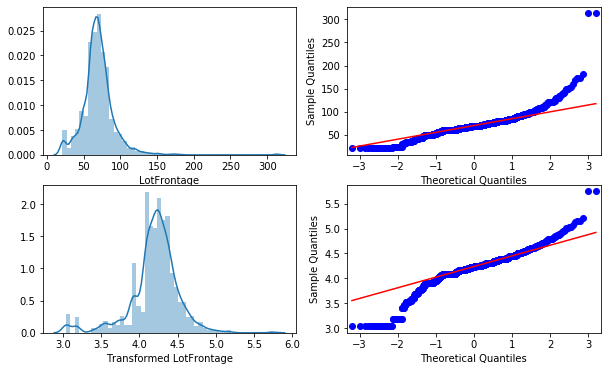

In [105]:
plot_dist("LotFrontage", features_df, 0)

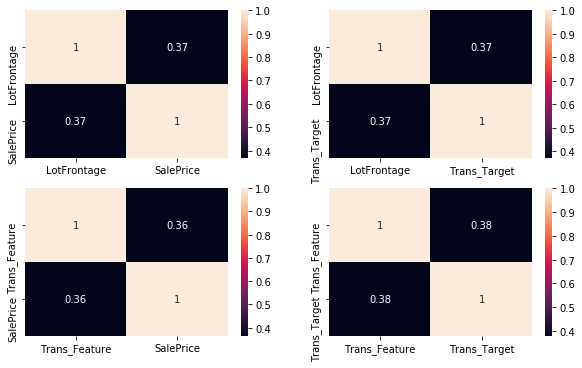

In [106]:
plot_heat("LotFrontage", "SalePrice", features_df, 0)

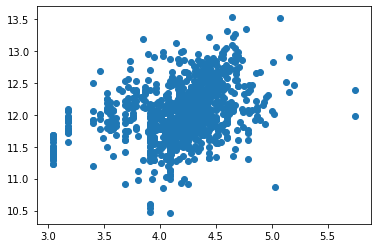

In [107]:
e = pow(10, -20)
plt.scatter(boxcox(features_df["LotFrontage"] + e, 0), np.log(features_df["SalePrice"]))
plt.show()

features_df["LotFrontage"] = boxcox(features_df["LotFrontage"] + e, 0)

### 2ndFlrSF

In [108]:
df = features_df[["2ndFlrSF", "SalePrice"]]
df.head()

,2ndFlrSF,SalePrice
0,854,208500
1,0,181500
2,866,223500
3,756,140000
4,1053,250000


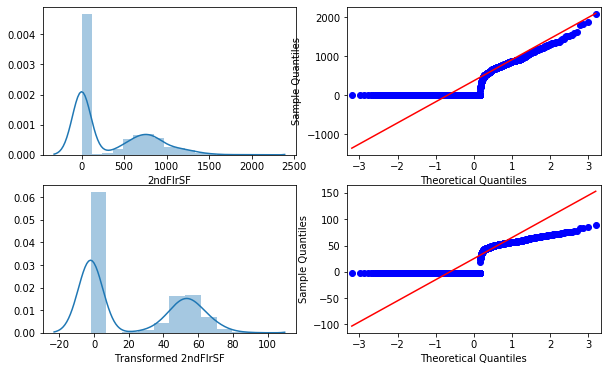

In [109]:
plot_dist("2ndFlrSF", df, 0.5)

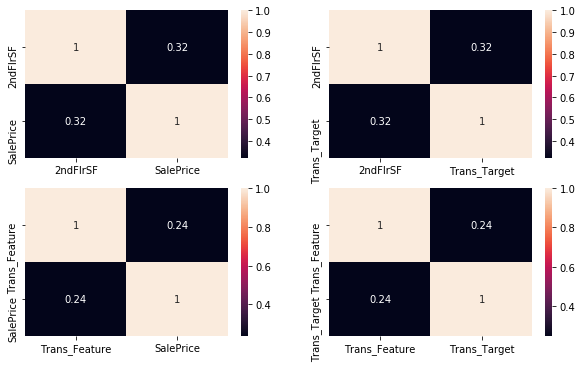

In [110]:
plot_heat("2ndFlrSF", "SalePrice", df, 0.5)

**Without 0's**

In [111]:
df = df[df["2ndFlrSF"] > 0]
df.shape

(631, 2)

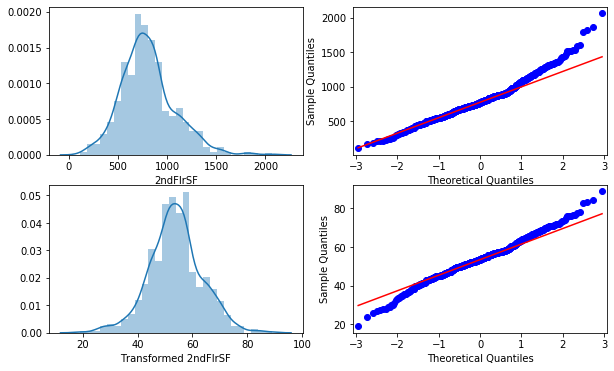

In [112]:
plot_dist("2ndFlrSF", df, 0.5)

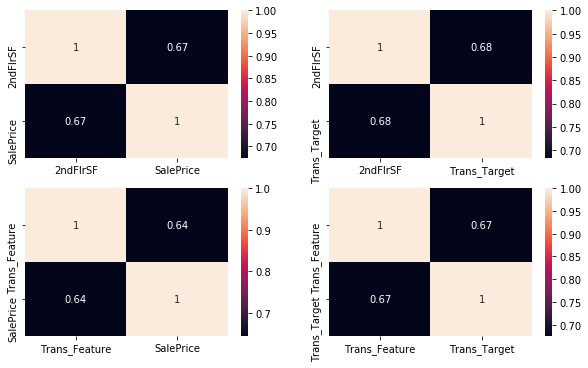

In [113]:
plot_heat("2ndFlrSF", "SalePrice", df, 0.5)

In [114]:
features_df["is_2ndFlrSF_0"] = np.where(features_df["2ndFlrSF"] == 0, 1, 0)

# Correlation with Target

In [115]:
features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 34 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   OverallQual      1460 non-null   int64  
 1   ExterQual        1460 non-null   int64  
 2   Foundation       1460 non-null   int64  
 3   BsmtQual         1460 non-null   int64  
 4   KitchenQual      1460 non-null   int64  
 5   FireplaceQu      1460 non-null   int64  
 6   GarageFinish     1460 non-null   int64  
 7   YearDiff         1460 non-null   float64
 8   YearRemodAdd     1460 non-null   float64
 9   1stFlrSF         1460 non-null   float64
 10  GrLivArea        1460 non-null   float64
 11  FullBath         1460 non-null   int64  
 12  GarageCars       1460 non-null   int64  
 13  Neighborhood     1460 non-null   int64  
 14  MasVnrType       1460 non-null   int64  
 15  HeatingQC        1460 non-null   int64  
 16  Fireplaces       1460 non-null   int64  
 17  MasVnrArea    

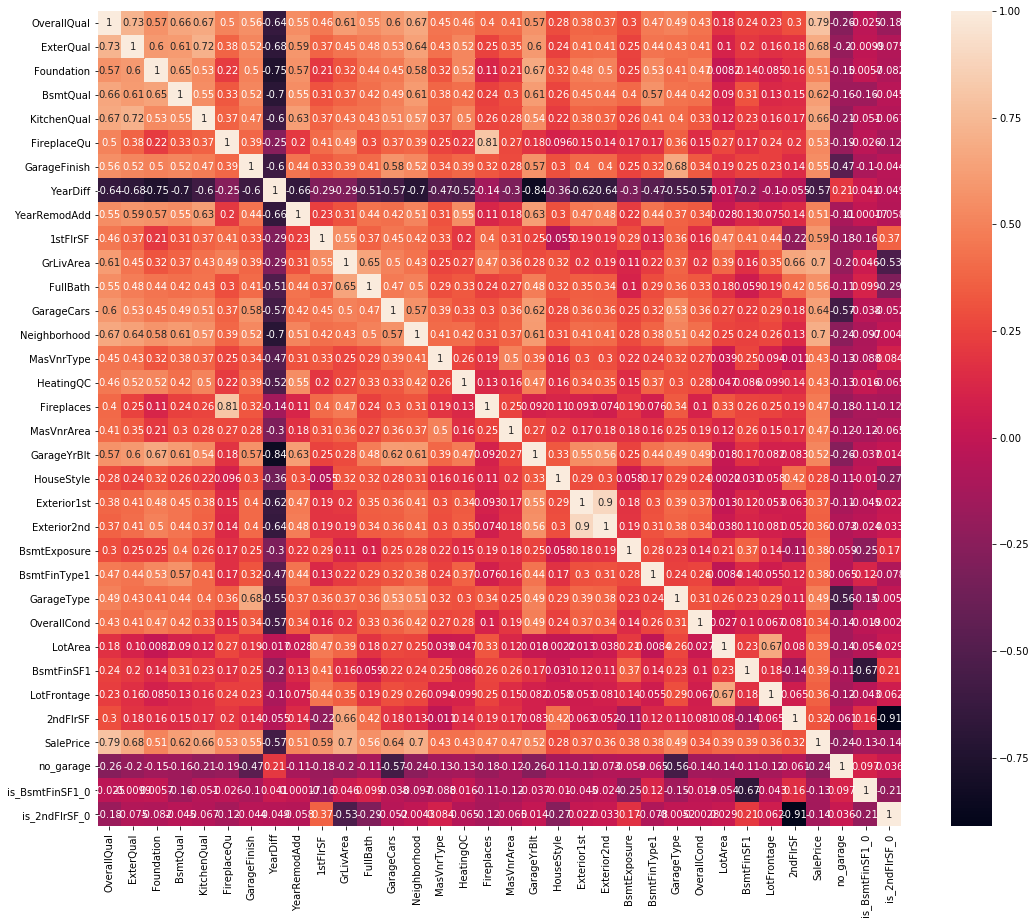

In [121]:
plt.rcParams["figure.figsize"] = 18, 15

sns.heatmap(features_df.corr(), annot = True)
plt.show()

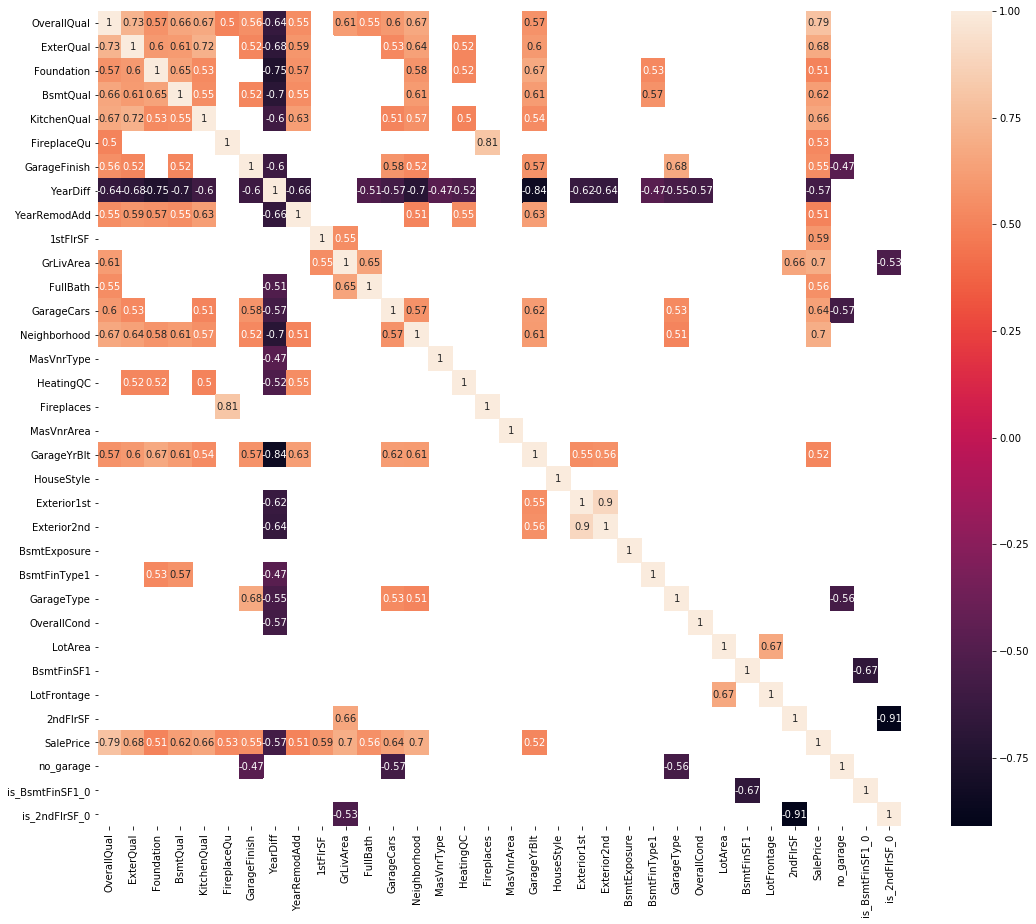

In [128]:
plt.rcParams["figure.figsize"] = 18, 15

sns.heatmap(features_df.corr(), annot = True, mask = (features_df.corr() < 0.5) & (features_df.corr() > -0.4))
plt.show()

# Exporting Preprocessed Train Set

In [146]:
train_features_df = features_df.copy()
train_features_df.to_csv("../Data/train_features_df.csv", index = False)